In [1]:

import pickle as pk
import numpy as np
from glob import glob

In [2]:
data_dir="../../data"
#!rm $data_dir/patches*.npz
!ls -lrt $data_dir/patches*.npz


-rw-r--r--  1 yoavfreund  staff  1178394690 Oct  9 15:55 ../../data/patches107.npz
-rw-r--r--  1 yoavfreund  staff  1420741098 Oct  9 15:58 ../../data/patches112.npz


In [3]:
s3files=!aws s3 ls s3://mousebraindata-open/MD657/patches/
    

In [20]:
for line in s3files[10:20]:
    parts=line.split()
    filename=parts[-1]
    print(filename)
    !aws s3 cp s3://mousebraindata-open/MD657/patches/$filename $data_dir

patches107.npz
download: s3://mousebraindata-open/MD657/patches/patches107.npz to ../../data/patches107.npz
patches108.npz
^Cmpleted 12.5 MiB/1.1 GiB (6.3 MiB/s) with 1 file(s) remaining   
patches109.npz MiB/1.1 GiB (6.5 MiB/s) with 1 file(s) remaining   
^C
Traceback (most recent call last):
  File "/Users/yoavfreund/anaconda3/bin/aws", line 19, in <module>
    import awscli.clidriver
  File "/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/awscli/clidriver.py", line 17, in <module>
    import botocore.session
  File "/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/botocore/session.py", line 25, in <module>
    import botocore.configloader
  File "/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/botocore/configloader.py", line 19, in <module>
    from botocore.compat import six
  File "/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/botocore/compat.py", line 25, in <module>
    from botocore.exceptions import MD5UnavailableError
  File "/Users/yoavfreund

UnboundLocalError: local variable 'child' referenced before assignment

In [5]:
patches=[]
filenames=glob(data_dir+'/patches*.npz')
for file in filenames[:2]:
    print(file)
    content=np.load(file)
    patches.append(content['Vout'])

../../data/patches112.npz
../../data/patches107.npz


In [7]:
combined=np.concatenate(patches)
combined.size/1000000.

324.891913

In [8]:
def permute(data):
    shuffle=np.random.permutation(data.shape[0])
    return data[shuffle,:,:]
scombined=permute(combined)
scombined.shape

(193273, 41, 41)

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel,convolve
gaussian = Gaussian2DKernel(1,x_size=7,y_size=7)
factor=sum(gaussian)
print('factor=',factor)
def calc_err(pic):
    P=convolve(pic,gaussian)/factor
    error=sqrt(mean(abs(pic-P)))
    sub=P[::2,::2]
    return error,sub

factor= 0.9994587918263369


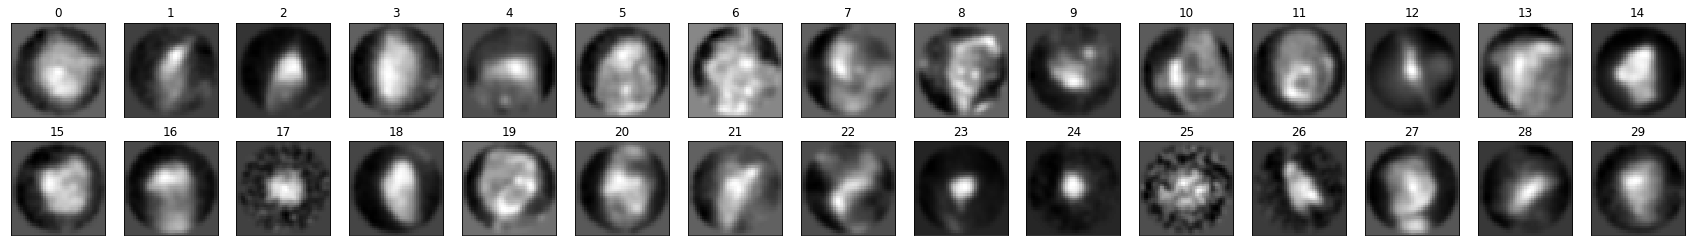

In [11]:
def plot_patches(data,h=40,w=15,_titles=[]):
    figure(figsize=(w*2,h*2))
    for i in range(h*w):
        if i>=data.shape[0]:
            break
        subplot(h,w,i+1);
        pic=data[i,:,:]
        P=convolve(pic,gaussian)/factor

        fig=imshow(P,cmap='gray')
        if(len(_titles)>i):
            plt.title(_titles[i])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plot_patches(scombined,h=2,_titles=[str(i) for i in range(scombined.shape[0])])

In [14]:
def pack_pics(Reps):
    size=Reps[0].shape[0]
    _len=len(Reps)
    Reps_mat=np.zeros([_len,size,size])
    for i in range(_len):
        Reps_mat[i,:,:]=Reps[i]
    return Reps_mat

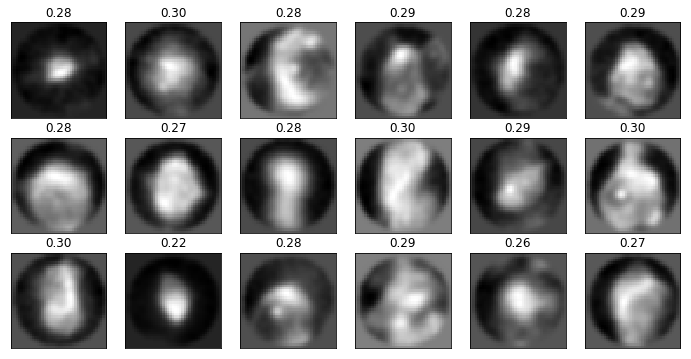

In [16]:
shift=1000
selected=[]
errors=[]
i=0; j=0;
while j < 50:
    pic=scombined[i+shift,:,:]
    i+=1
    error,sub=calc_err(pic)
    if error>0.3:
        continue
    j+=1
    selected.append(pic)
    errors.append('%4.2f'%error)
plot_patches(pack_pics(selected),h=3,w=6,_titles=errors)

In [17]:
#collect images that are pretty smooth
# reduce resolution by a factor of 2
low_err=[]
i=0
while len(low_err) <1000000:
    if i >= scombined.shape[0]:
        break
    pic=scombined[i,:,:]
    i+=1
    error,sub=calc_err(pic)
    if error<0.3:
        low_err.append(sub)
        j=len(low_err)
        if j%1000==0:
            print('\r',i,j,end='')

lcombined=np.stack(low_err)
lcombined.shape

 192550 78000

(78308, 21, 21)

In [18]:
def dist2(a,b):
    diff=(a-b)**2
    return sum(diff.flatten())

In [19]:
D=[]
for i in range(1,lcombined.shape[0]):
    D.append(dist2(lcombined[i,:,:],lcombined[i-1,:,:]))
    if i%1000==0:
        print('\r',i,end='')

 78000

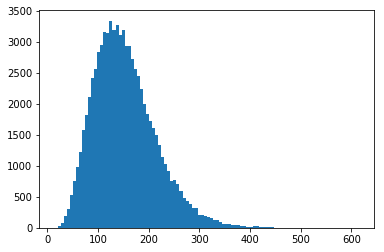

In [20]:
hist(D,bins=100);

In [21]:
max(D)

615.2898497076555

In [23]:
def refineKmeans(data,Reps):
    new_Reps=[np.zeros(Reps[0].shape) for r in Reps]
    Reps_count=[0.0 for r in Reps]
    error=0
    for i in range(data.shape[0]): 
        patch=data[i,:,:]
        dists=[dist2(patch,r) for r in Reps]
        _argmin=argmin(dists)
        _min=min(dists)
        new_Reps[_argmin]+=patch
        Reps_count[_argmin]+=1
        error+=_min
    error /= data.shape[0]
    for i in range(len(new_Reps)):
        new_Reps[i]/=Reps_count[i]
    return new_Reps,Reps_count,error

In [24]:
def Kmeans(data,n=100,scale=550):
    Reps,Statistics = Kmeanspp(data,n,scale)
    for i in range(5):
        Reps,error = refineKmeans(data,Reps)
        print('refine iteration %2d, error=%7.3f'%(i,error))

In [25]:
def Kmeanspp(data,n=100,scale=550):
    Reps=[data[0,:,:]]

    Statistics=[]
    j=1
    for i in range(1,data.shape[0]): 
        _min=100000
        patch=data[i,:,:]
        for r in Reps:
            _min=min(_min,dist2(patch,r))
        Prob=_min/scale
        print('\r','i=%10d,  #reps=%10d  Prob=%8.6f'%(i,len(Reps),Prob),end='')
        Statistics.append((i,len(Reps),_min))
        if np.random.rand()<Prob:
            Reps.append(patch)
            j+=1
        if j>=n:
            break
    return Reps,Statistics

In [26]:
def plot_statistics(Statistics,alpha=0.05,_start=10): 
    N=[x[1] for x in Statistics]
    d=[x[2] for x in Statistics]

    s=mean(d[:_start])
    smoothed=[s]*_start
    for x in d[_start:]:
        s=(1-alpha)*s + alpha*x
        smoothed.append(s)
    loglog(N[_start:],smoothed[_start:])
    xlabel('N')
    ylabel('smoothed distance')
    grid(which='both')

 i=        56,  #reps=         9  Prob=0.103981

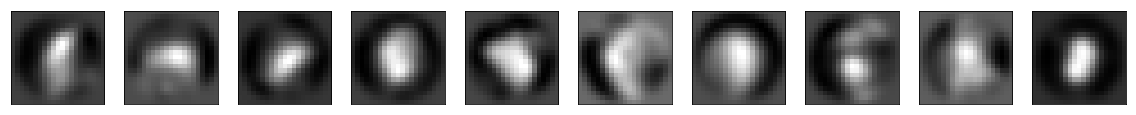

In [27]:
N=10
Reps, Statistics = Kmeanspp(lcombined,n=N)
Reps_mat = pack_pics(Reps)
plot_patches(Reps_mat,h=5,w=10)

87.52417938673634


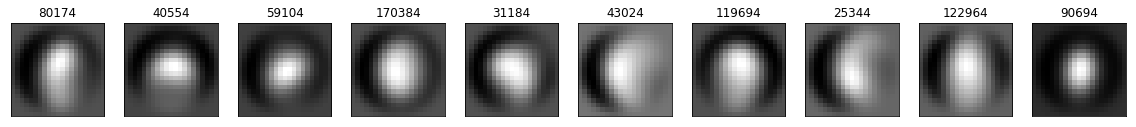

In [28]:
new_Reps,Reps_count,error = refineKmeans(lcombined,Reps)
print(error)
Reps_mat = pack_pics(new_Reps)

plot_patches(Reps_mat,h=5,w=10,_titles=['%d4'%x for x in Reps_count])

partition 0
 i=        60,  #reps=         9  Prob=0.244398partition 1
 i=        38,  #reps=         9  Prob=0.161095partition 2
 i=        60,  #reps=         9  Prob=0.178719partition 3
 i=        65,  #reps=         9  Prob=0.282780partition 4
 i=        53,  #reps=         9  Prob=0.213628partition 5
 i=        48,  #reps=         9  Prob=0.175838partition 6
 i=        79,  #reps=         9  Prob=0.234255partition 7
 i=        39,  #reps=         9  Prob=0.121319partition 8
 i=        67,  #reps=         9  Prob=0.278377partition 9
 i=        55,  #reps=         9  Prob=0.091727partition 10
 i=        50,  #reps=         9  Prob=0.155341partition 11
 i=        33,  #reps=         9  Prob=0.174594partition 12
 i=        63,  #reps=         9  Prob=0.185471partition 13
 i=        45,  #reps=         9  Prob=0.157867partition 14
 i=        31,  #reps=         9  Prob=0.119826partition 15
 i=        66,  #reps=         9  Prob=0.189870partition 16
 i=        54,  #reps=         9  Pro

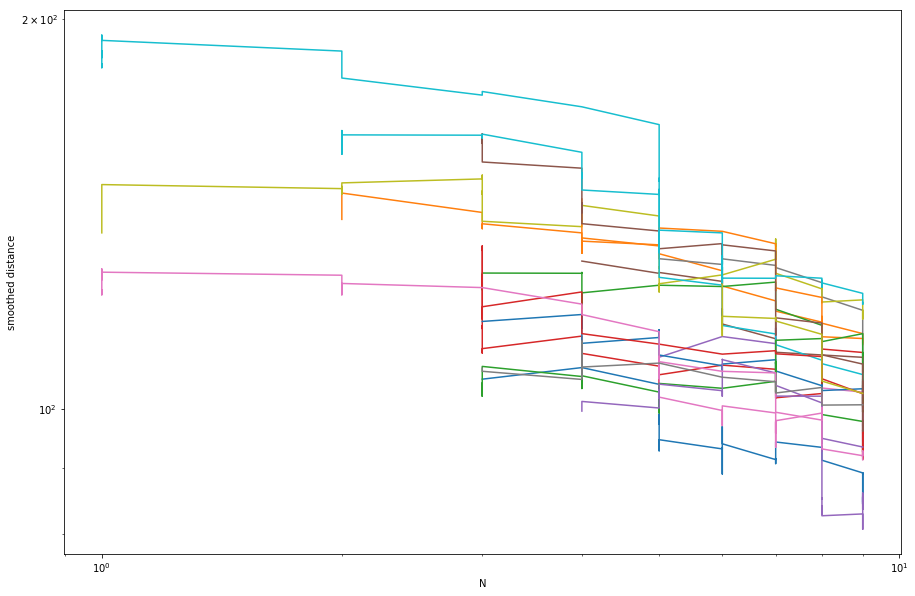

In [29]:
# Generate K different partitions

K=20 # number of independent partitions
N =10 # number of parts in each partition
Multi_Rep=[]
figure(figsize=[15,10])
for i in range(K):
    print('partition',i)
    lcombined=permute(lcombined)
    Reps, Statistics = Kmeanspp(lcombined,n=N)
    new_Reps,Reps_count,error = refineKmeans(lcombined,Reps)
    Multi_Rep.append(new_Reps)
    plot_statistics(Statistics)


In [30]:
len(Multi_Rep)

20

In [32]:
stacks=[]
for Rep in Multi_Rep:
    stacks.append(np.stack(Rep))
All=np.stack(stacks)
All.shape

(20, 10, 21, 21)

In [33]:
pic=np.zeros([1,1,21,21])

all_labels=[]

mean_vecs=np.zeros([])
for i in range(lcombined.shape[0]):
    pic[0,0,:,:]=lcombined[i,:,:]

    diff=(All-pic)**2
    dists=np.sum(np.sum(diff,axis=2),axis=2)
    labels=np.argmin(dists,axis=1)
    all_labels.append(tuple(labels))
    if i%1000==0:
        print('\r',i,end='')

 78000

In [34]:
len(all_labels[0])

20

In [35]:
from collections import Counter

def calc_entropy(all_labels,i=0,j=1,threshold=1):
    c=Counter([x[i:j] for x in all_labels])
    counts=np.array(list(c.values()),dtype=np.float)
    counts1=counts[counts>threshold]
    leftout=sum(counts)-sum(counts1)
    if leftout>0:
        counts1=np.concatenate([np.array([leftout]),counts1])
    P=counts1/sum(counts1)
    return np.sum(P*log(1/P)),counts1,c
#calc_entropy(all_labels,i=0,j=3)

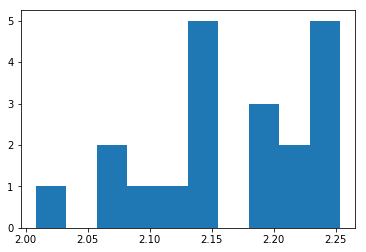

In [36]:
H=[]
for i in range(K):
    H.append(calc_entropy(all_labels,i=i,j=i+1)[0])

hist(H);

In [37]:
cumH=np.concatenate([np.zeros(1),cumsum(H)])
cumH

array([ 0.        ,  2.11611951,  4.12437104,  6.22121388,  8.36018674,
       10.50696253, 12.65258685, 14.80075212, 17.04254245, 19.24099876,
       21.48222127, 23.67073031, 25.73873652, 27.86987891, 30.07113244,
       32.28053994, 34.5315313 , 36.74386296, 38.97402818, 41.22774206,
       43.29450291])

In [38]:
HC=[]
counts_vecs=[]
for i in range(K):
    H,counts,c=calc_entropy(all_labels,i=0,j=i)
    HC.append(H)
    counts_vecs.append(counts)

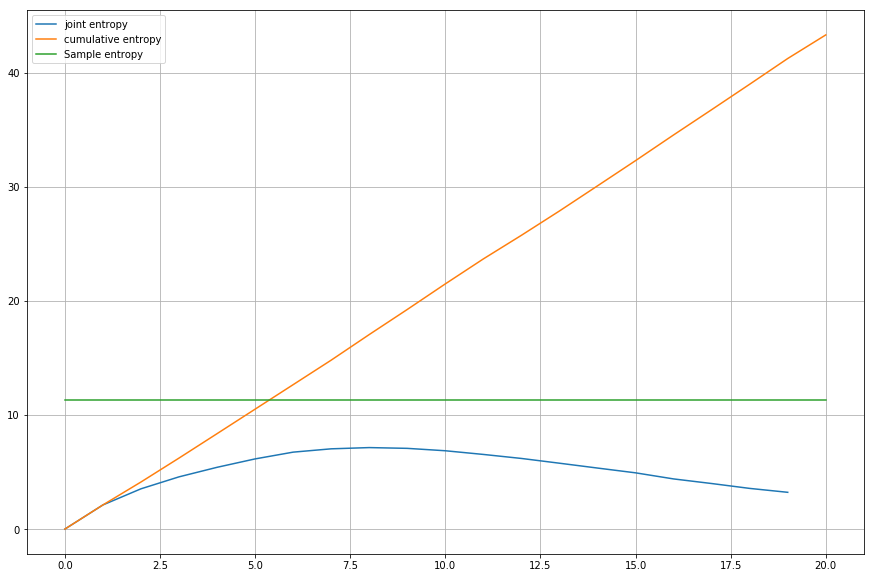

In [39]:
figure(figsize=[15,10])
j=K+1
plot(HC[:j],label='joint entropy')
plot(cumH[:j],label='cumulative entropy')
sample_H = log(len(all_labels))
plot([sample_H]*j,label='Sample entropy')
grid()
legend()

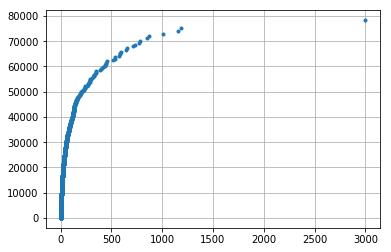

In [56]:
K1=6
H,counts,c=calc_entropy(all_labels,i=0,j=K1)

sc=sort(counts)
plot(sc,cumsum(sc),'.');
grid()

In [57]:
sc[-20:]

array([ 461.,  514.,  538.,  539.,  574.,  581.,  583.,  597.,  642.,
        657.,  716.,  735.,  776.,  783.,  854.,  875., 1006., 1158.,
       1184., 2998.])

36
 78000
0 (8, 9, 6, 3, 7, 8) (353, 21, 21)
1 (6, 1, 6, 3, 7, 9) (642, 21, 21)
2 (6, 1, 6, 1, 7, 3) (384, 21, 21)
3 (6, 9, 6, 3, 7, 8) (324, 21, 21)
4 (4, 3, 9, 7, 4, 4) (854, 21, 21)
5 (4, 3, 3, 4, 1, 6) (1184, 21, 21)
6 (3, 7, 7, 6, 5, 3) (325, 21, 21)
7 (2, 9, 6, 5, 7, 8) (1158, 21, 21)
8 (3, 7, 7, 6, 5, 7) (597, 21, 21)
9 (6, 1, 6, 3, 7, 8) (538, 21, 21)
10 (2, 9, 6, 5, 2, 8) (735, 21, 21)
11 (4, 3, 2, 1, 1, 6) (581, 21, 21)
12 (2, 9, 6, 5, 2, 9) (583, 21, 21)
13 (0, 1, 1, 0, 0, 1) (420, 21, 21)
14 (2, 9, 6, 5, 9, 8) (783, 21, 21)
15 (6, 1, 6, 1, 7, 6) (574, 21, 21)
16 (6, 9, 6, 5, 2, 6) (875, 21, 21)
17 (6, 9, 6, 1, 2, 6) (657, 21, 21)
18 (2, 9, 6, 3, 7, 8) (514, 21, 21)
19 (9, 3, 3, 4, 1, 4) (449, 21, 21)
20 (2, 9, 6, 3, 7, 9) (461, 21, 21)


/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21 (9, 3, 3, 4, 1, 6) (539, 21, 21)
22 (6, 5, 3, 4, 1, 6) (451, 21, 21)
23 (6, 3, 3, 4, 1, 6) (436, 21, 21)
24 (2, 9, 6, 5, 7, 9) (776, 21, 21)
25 (4, 3, 2, 1, 1, 4) (716, 21, 21)
26 (6, 1, 2, 1, 1, 3) (395, 21, 21)
27 (0, 7, 1, 6, 0, 1) (1006, 21, 21)
28 (8, 1, 6, 3, 7, 9) (411, 21, 21)
29 (2, 9, 6, 5, 2, 6) (307, 21, 21)
30 (6, 1, 6, 1, 2, 3) (331, 21, 21)
31 (6, 1, 6, 1, 2, 6) (433, 21, 21)
32 (4, 3, 3, 4, 1, 5) (322, 21, 21)
33 (5, 1, 9, 0, 4, 4) (350, 21, 21)
34 (9, 3, 2, 1, 1, 4) (351, 21, 21)
35 (6, 7, 7, 1, 2, 3) (334, 21, 21)


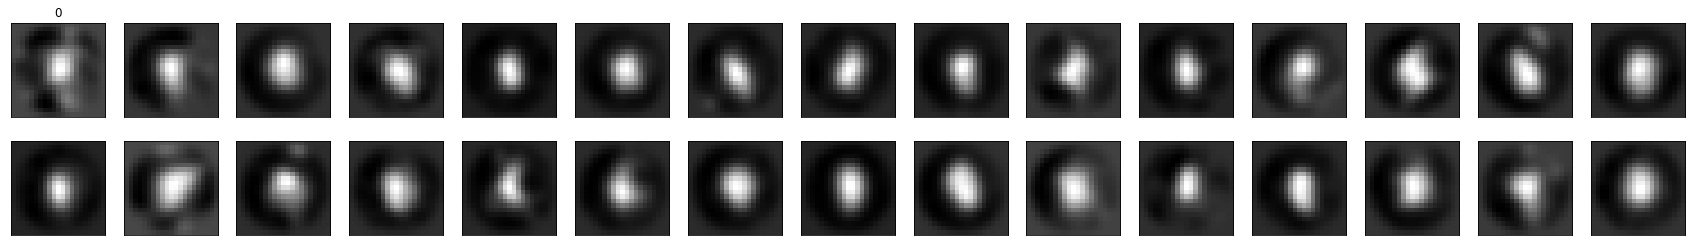

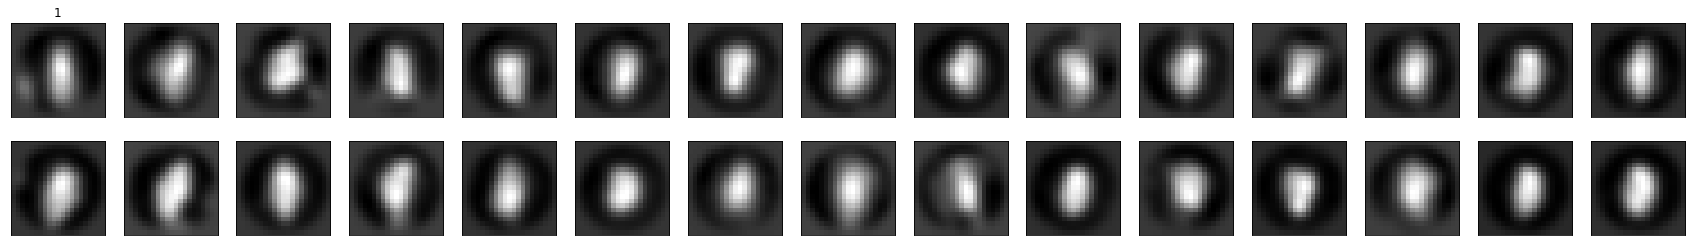

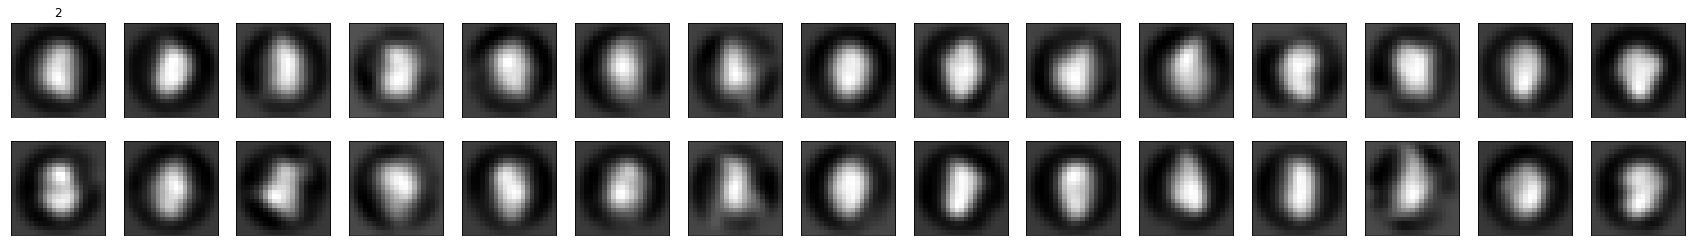

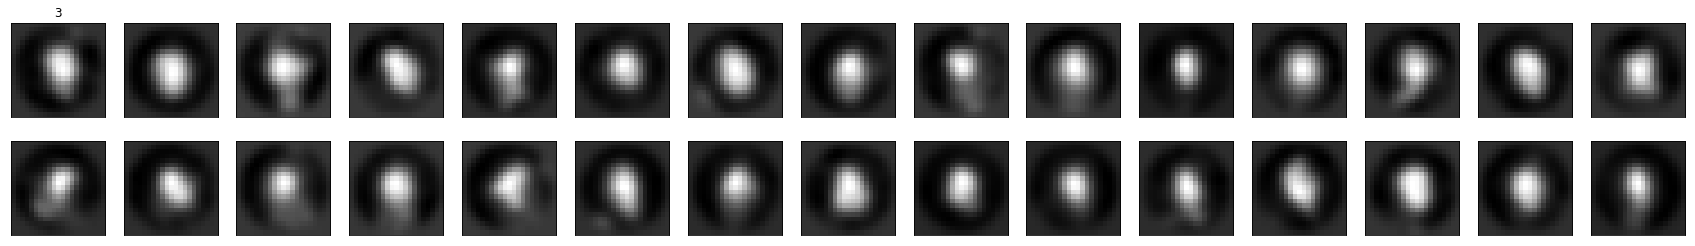

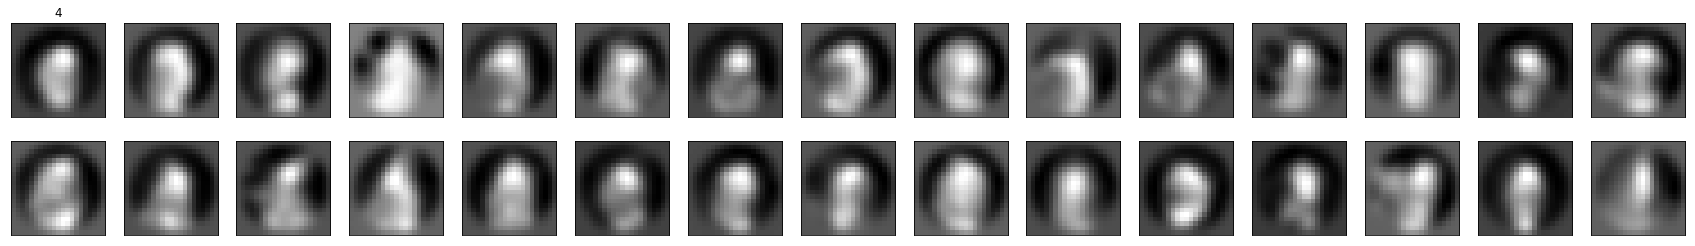

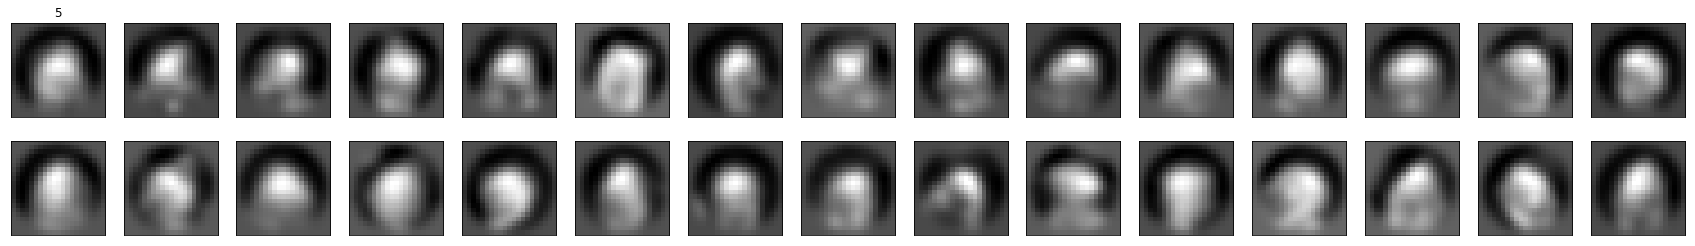

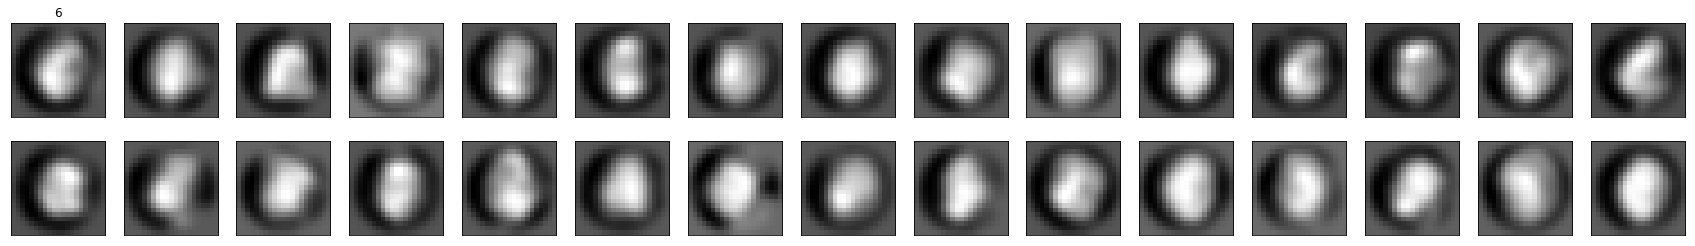

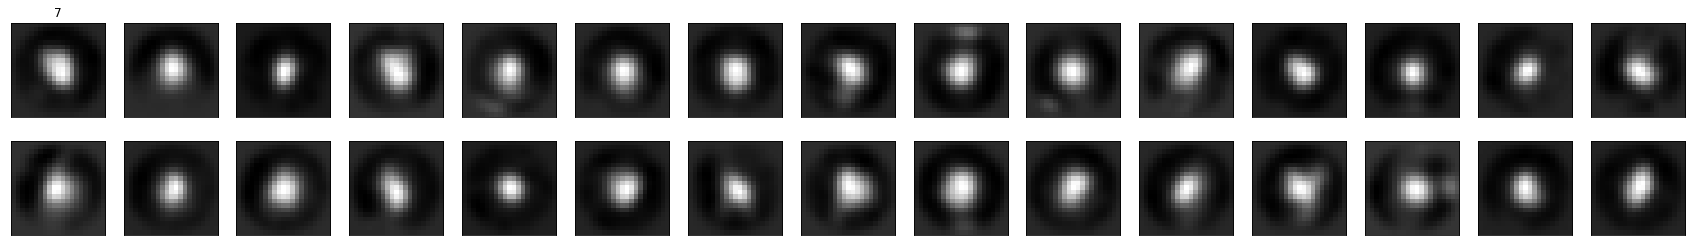

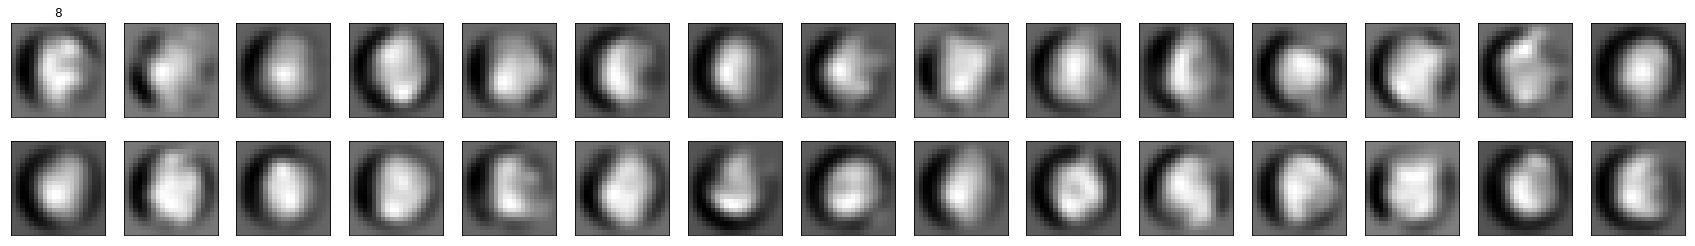

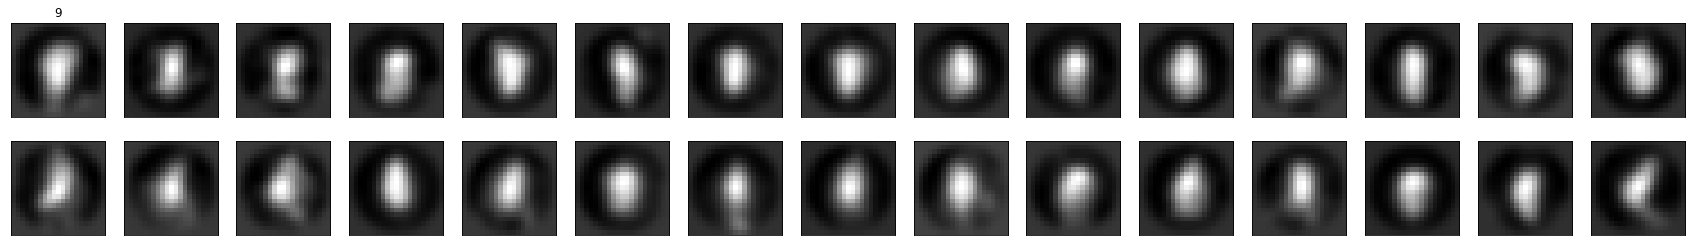

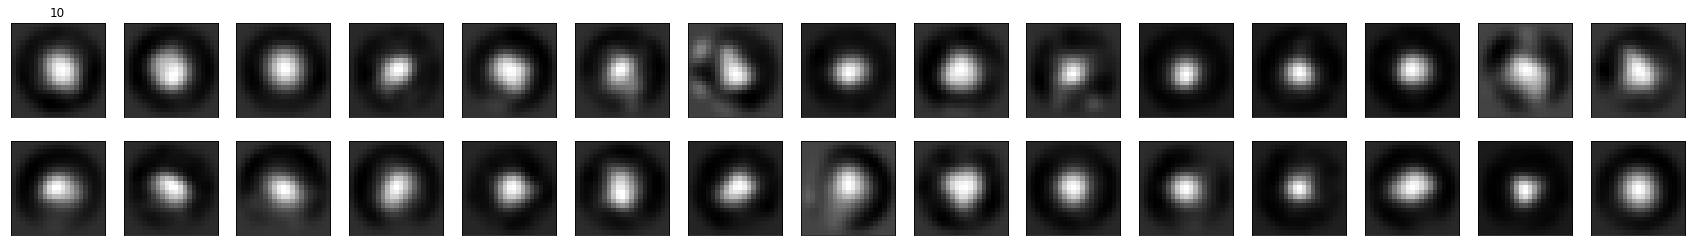

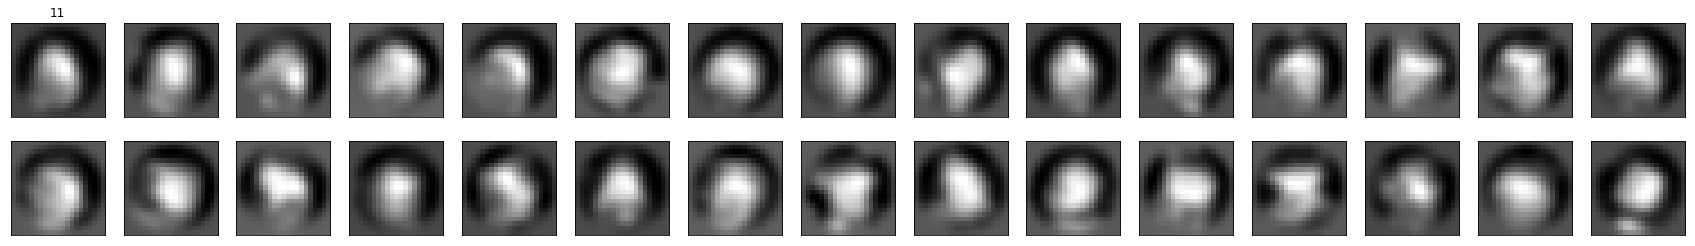

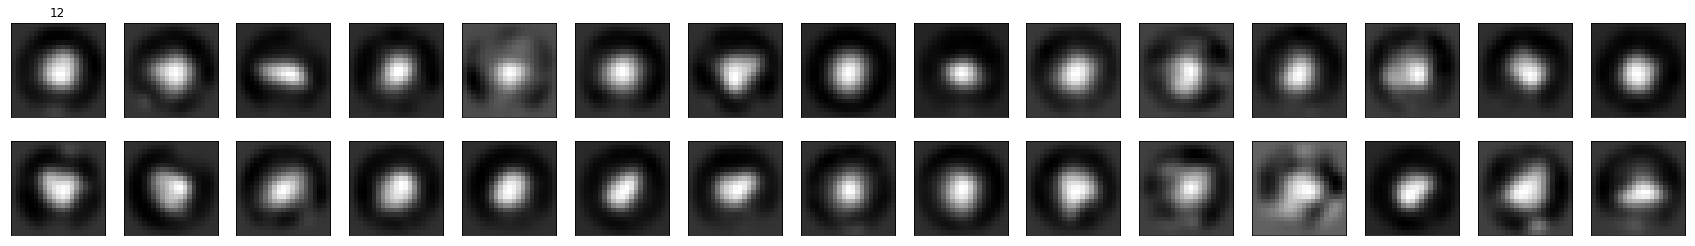

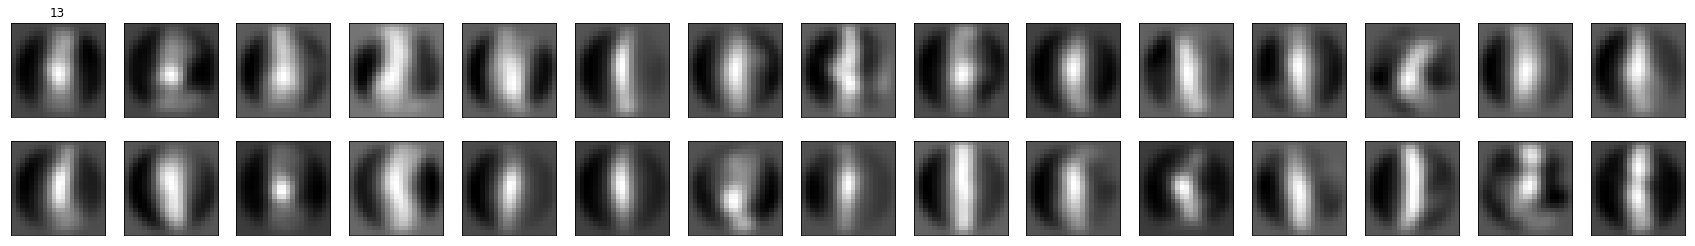

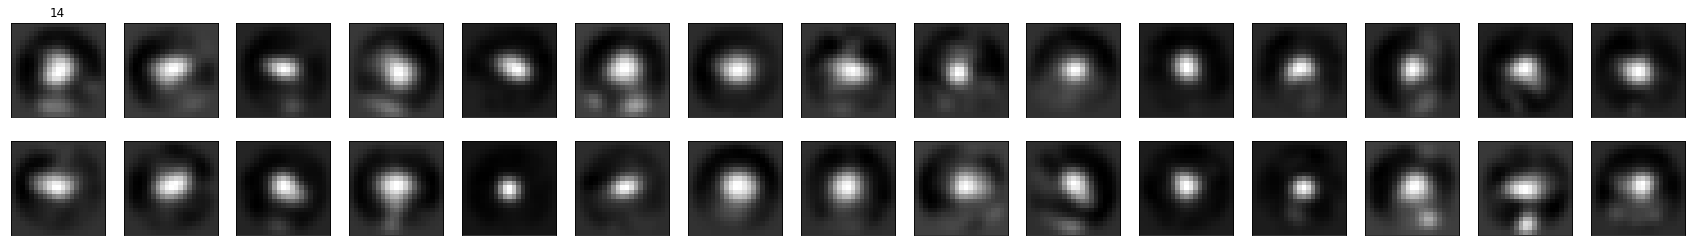

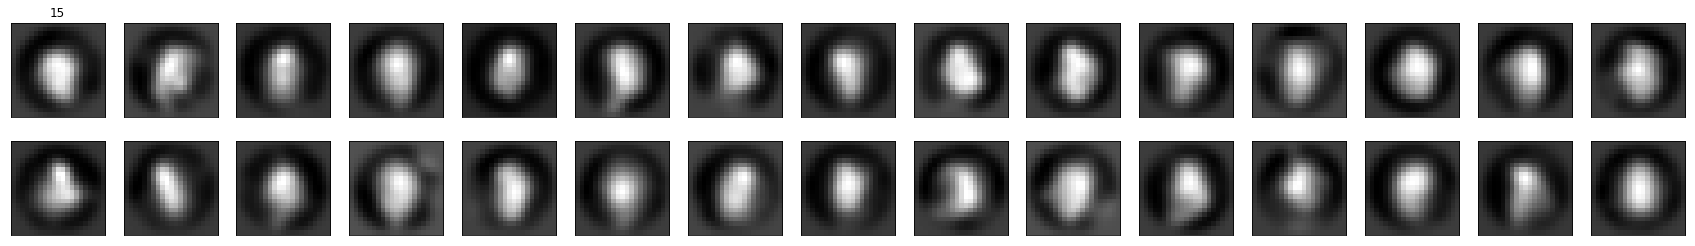

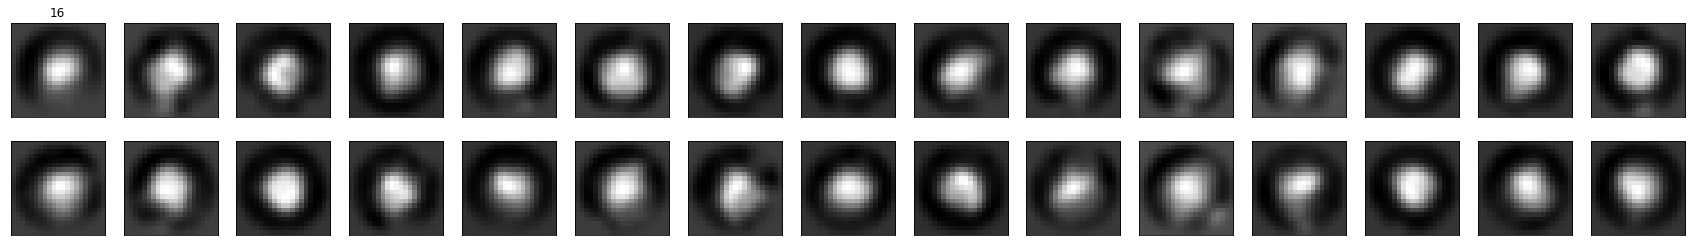

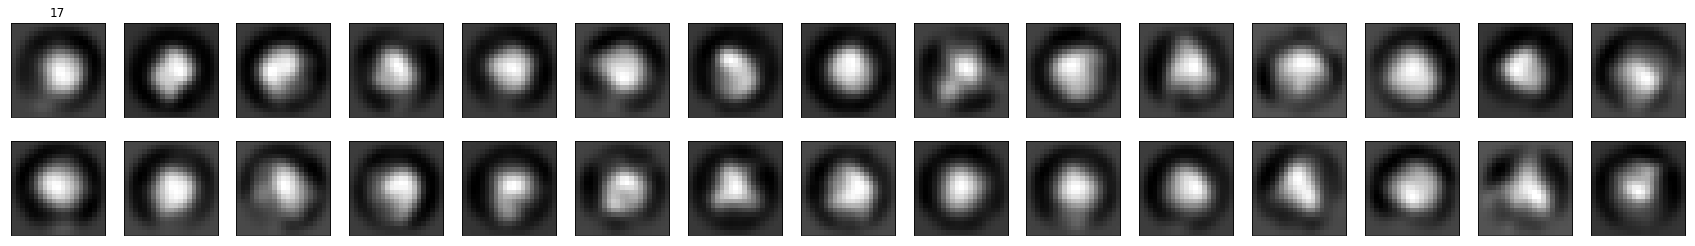

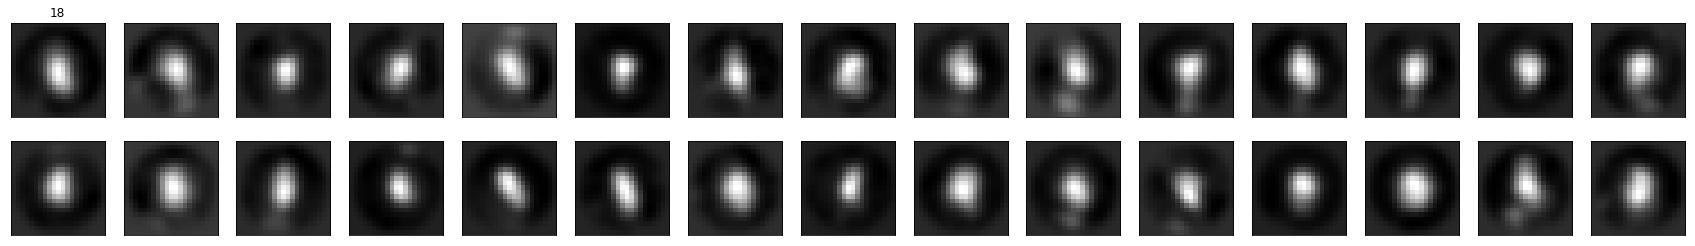

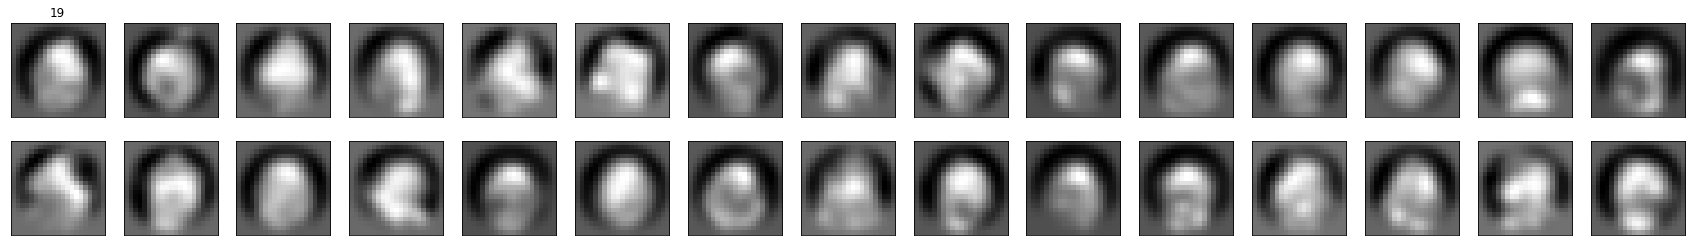

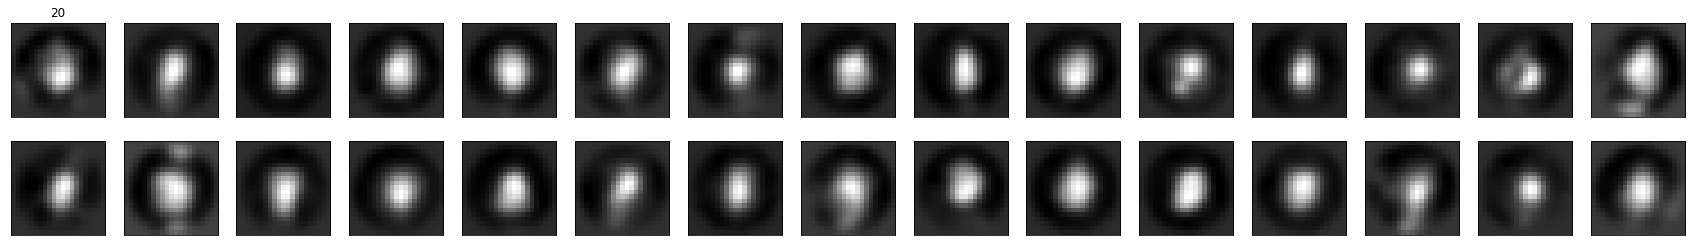

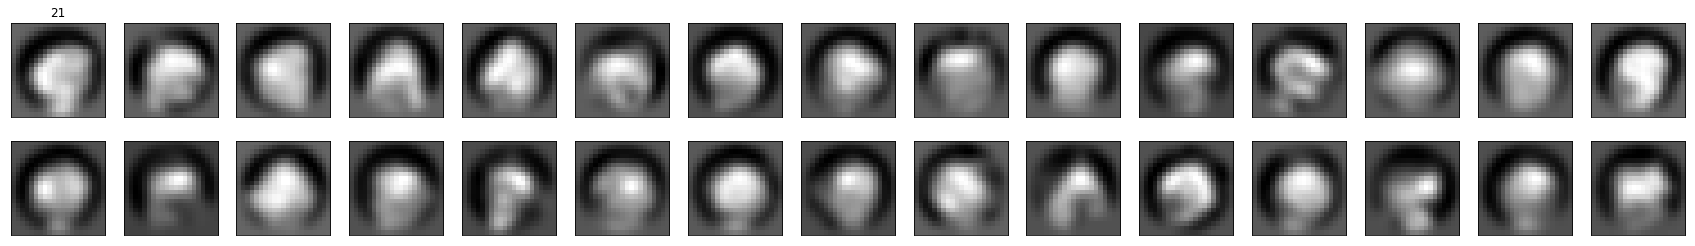

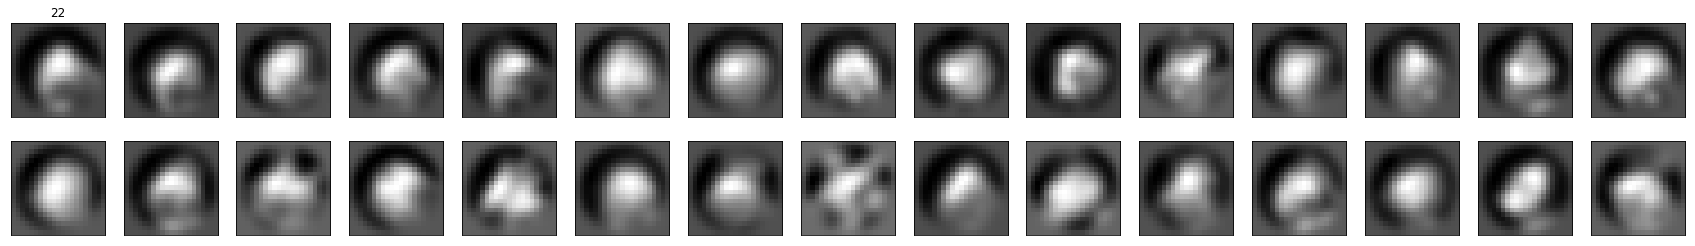

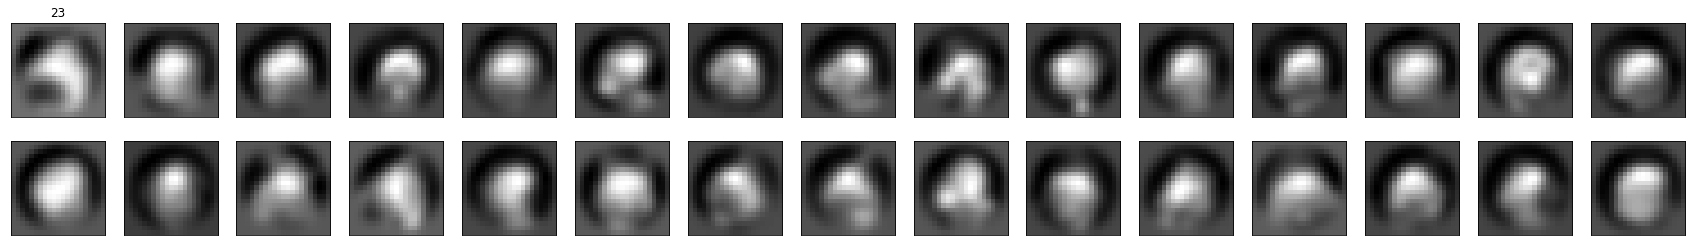

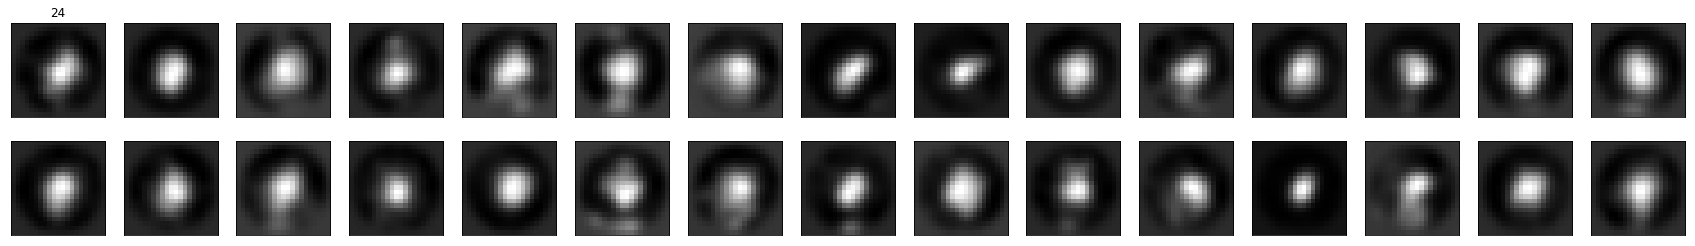

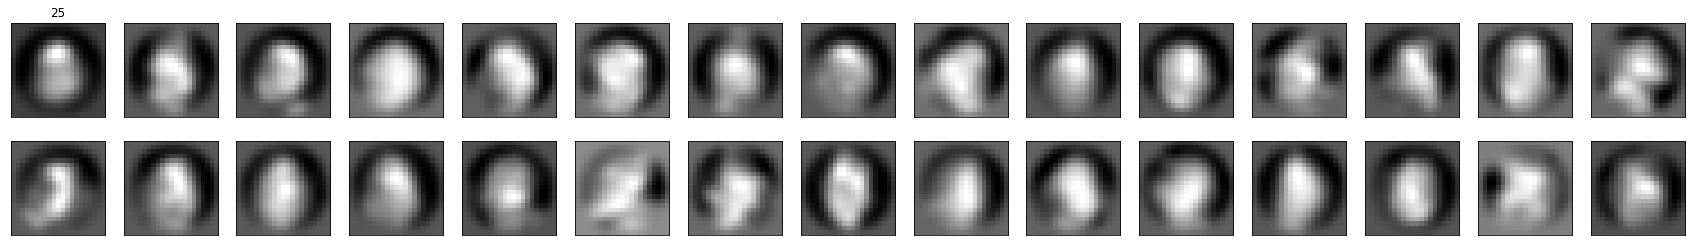

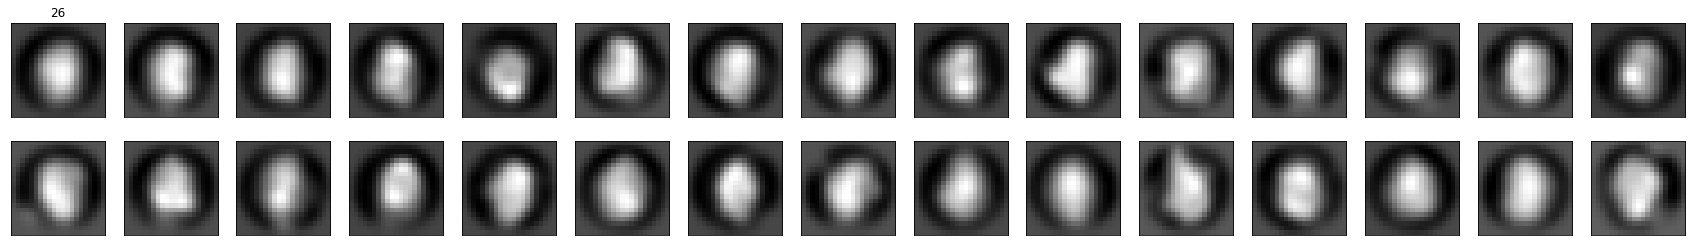

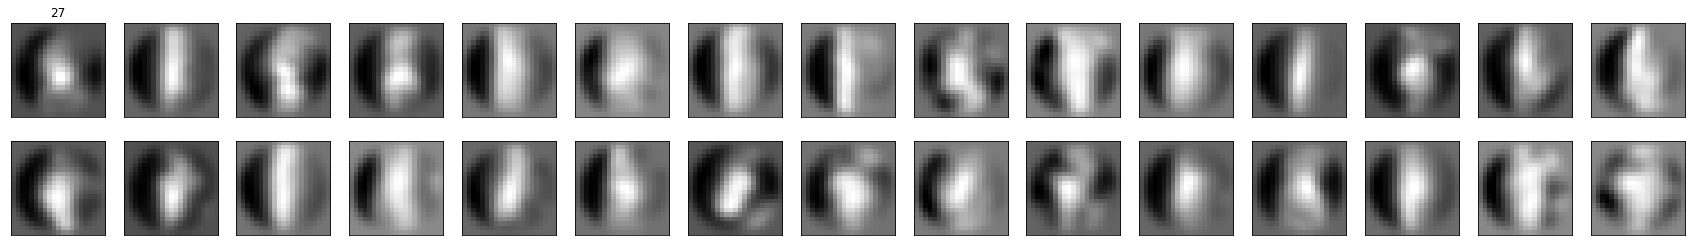

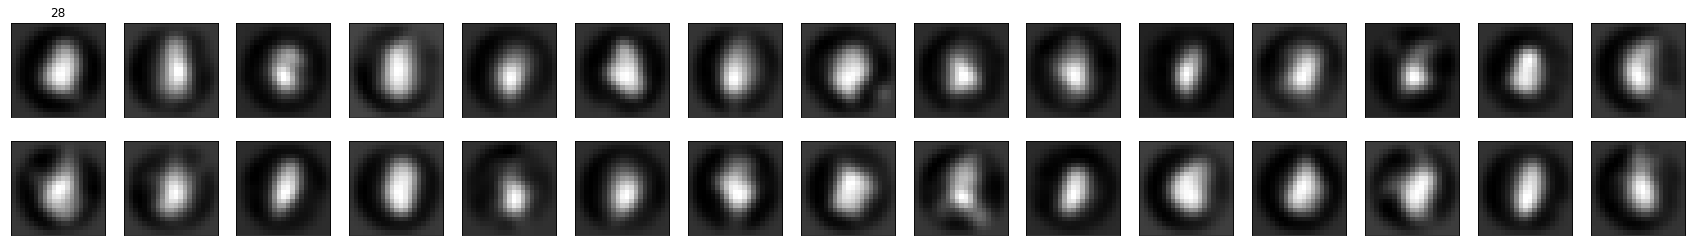

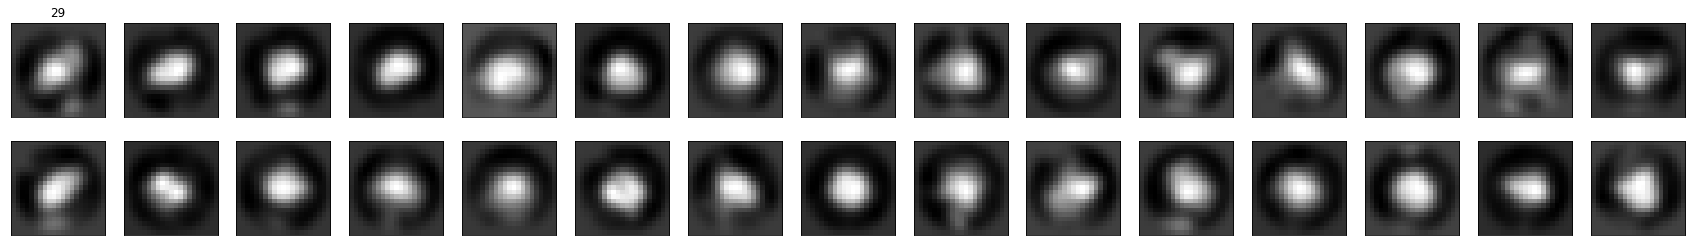

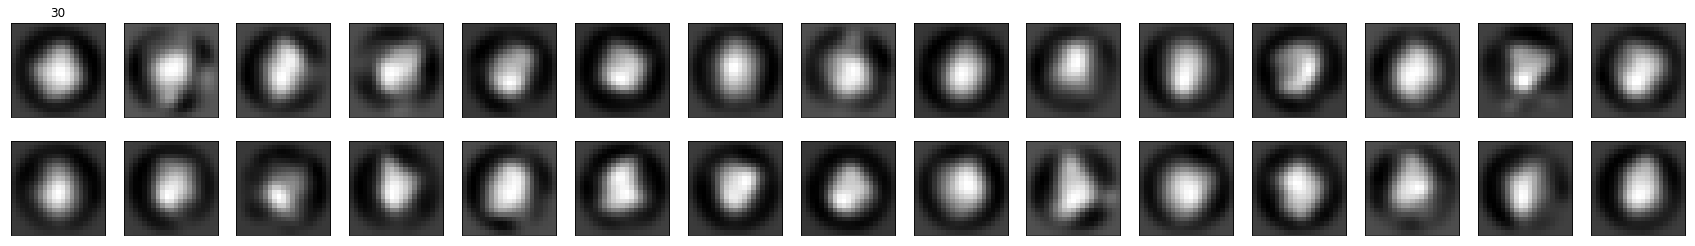

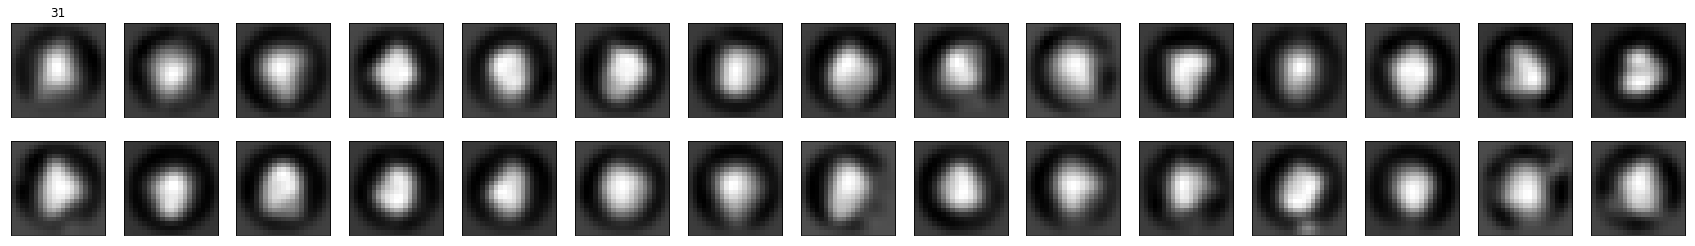

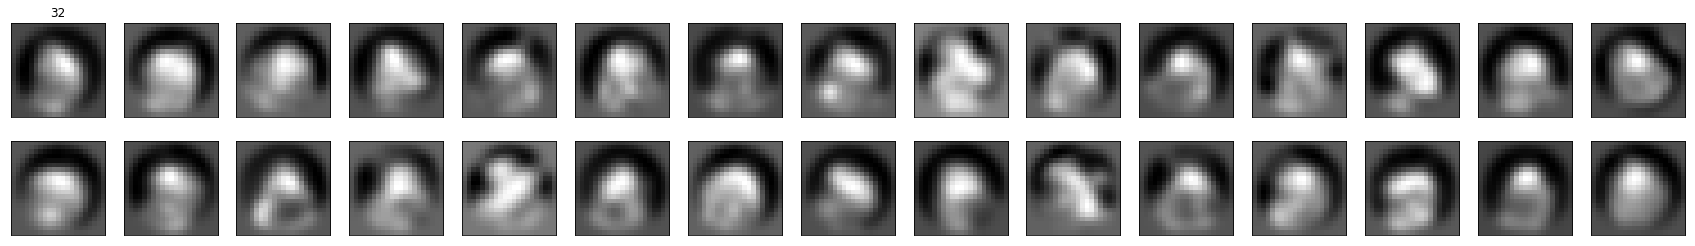

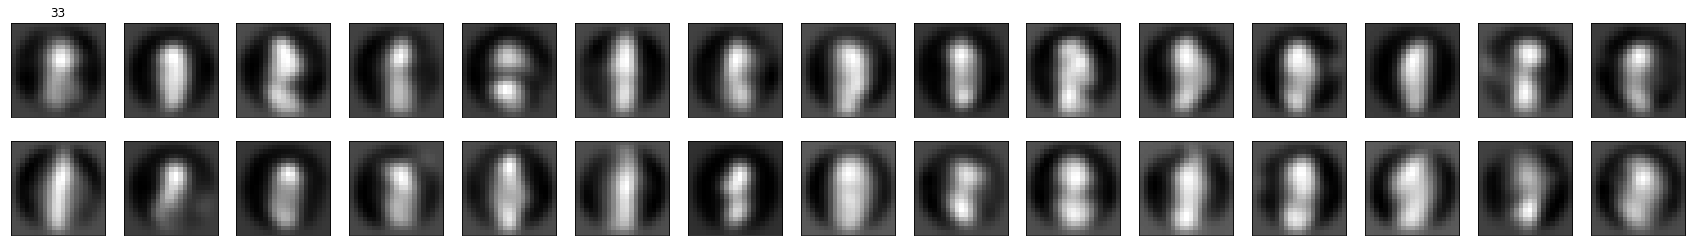

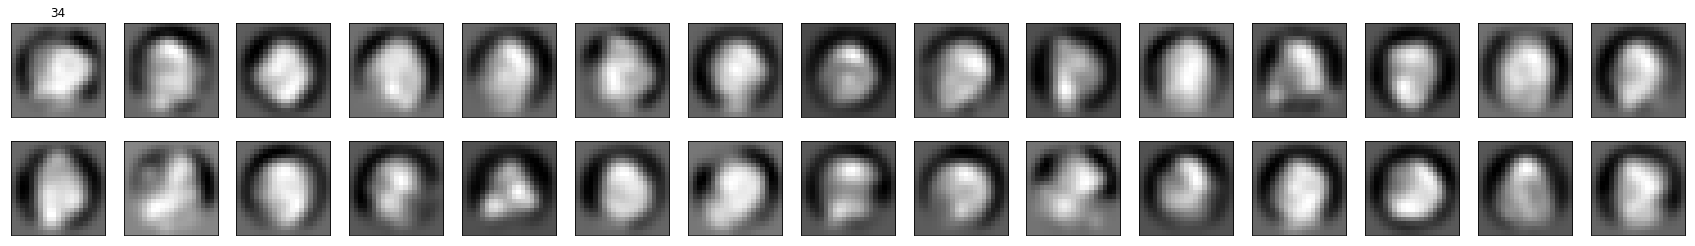

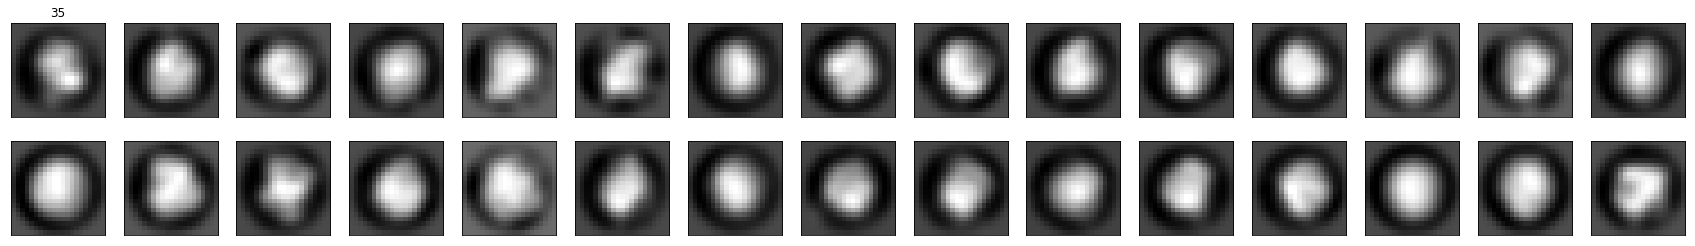

In [59]:
size=300
core_sets={x[0]:[] for x in c.items() if x[1]>size}
print(len(core_sets))

[x for x in c.items() if x[1]>size]

lcombined.shape[0]/(3**8)

for i in range(len(all_labels)):
    vec=all_labels[i][:K1]
    if i%1000 == 0:
        print('\r',i,end='')
    if vec in core_sets:
        core_sets[vec].append(i)
        #print(vec,core_sets[vec])

len(all_labels),lcombined.shape
print()
i=0
for key in core_sets.keys():
    data=lcombined[core_sets[key],:,:]
    print(i,key,data.shape)
    plot_patches(data,h=2,_titles=[str(i)])
    i+=1

## finding neighborhoods in the coding graph

In [60]:
len(c)

6813

In [61]:
cells=list(c.items())
cells=sorted(cells,key=lambda x:x[1],reverse=True)
cells[:10]

[((4, 3, 3, 4, 1, 6), 1184),
 ((2, 9, 6, 5, 7, 8), 1158),
 ((0, 7, 1, 6, 0, 1), 1006),
 ((6, 9, 6, 5, 2, 6), 875),
 ((4, 3, 9, 7, 4, 4), 854),
 ((2, 9, 6, 5, 9, 8), 783),
 ((2, 9, 6, 5, 7, 9), 776),
 ((2, 9, 6, 5, 2, 8), 735),
 ((4, 3, 2, 1, 1, 4), 716),
 ((6, 9, 6, 1, 2, 6), 657)]

In [62]:
def hamming(a,b):
    assert len(a)==len(b)
    d=0
    for i in range(len(a)):
        if a[i]!=b[i]:
            d+=1
    return d

clusters=[[[x]] for x in c.items() if x[1]>size]
for cluster in clusters:
    last_layer=cluster[-1]
    #print('last_layer=',last_layer)
    new_layer=[]
    for x in c.items():
        new_key=x[0]
        for e in last_layer:
            #print(e,new_key)
            if hamming(e[0],new_key)<2:
                new_layer.append(x)
    cluster.append(new_layer)
            
        
            
            
    

In [63]:
layers=[set([x[0] for x in cluster[1]]) for cluster in clusters]
L=len(layers)
Count=np.zeros([L,L])
for i in range(len(layers)-1):
    for j in range(i+1,len(layers)):
        Count[i,j]=len(layers[i] & layers[j])
        Count[j,i]=len(layers[i] & layers[j])

print('   ',''.join(['%3d'%l for l in range(L)]))
for i in range(L):
    print('%3d'%i,''.join(['%3d'%l for l in Count[i,:]]))

      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
  0   0  0  0  7  0  0  0  2  0  2  0  0  0  0  0  0  0  0  7  0  2  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0
  1   0  0  2  2  0  0  0  0  0  6  0  0  0  0  0  2  0  0  0  0  2  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0
  2   0  2  0  0  0  0  0  0  0  2  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  2  0  0  0  4  2  0  0  0  0
  3   7  2  0  0  0  0  0  2  0  3  0  0  0  0  0  0  0  0  7  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  4   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  5   0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  2  0  5  2  5  0  0  0  0  0  0  0  0  4  0  0  0
  6   0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  7   2  0  0  2  0  0  0  0  0  0  5  0  2  0  5  0  0  0  3  0  2  0  0  0  6  0  0  0  0  2  

In [140]:
for i in range(len(clusters)):
    total=sum([x[1] for x in clusters[i][1]])
    print(clusters[i][0],total)

[((0, 1, 1), 1162)] 8023
[((1, 3, 0), 525)] 3380
[((0, 1, 8), 1860)] 7929
[((3, 8, 5), 2388)] 5913
[((6, 4, 8), 1410)] 3789
[((3, 8, 9), 576)] 3597
[((2, 3, 5), 868)] 3639
[((3, 3, 5), 506)] 6346
[((0, 1, 5), 1289)] 8625
[((6, 1, 8), 737)] 4929
[((0, 5, 1), 549)] 3353
[((0, 1, 0), 742)] 7990
[((3, 1, 5), 643)] 6530
[((0, 1, 6), 964)] 7402
[((4, 1, 0), 511)] 3642
[((4, 3, 0), 844)] 3664


In [141]:
#computing the mean
Multi_Rep[0][0].shape

(21, 21)

In [119]:
len(Multi_Rep[0])

3